# 分子基础操作与药效团查找

## 1.原子操作

在rdkit中，分子中的每一个原子都是对象，可以通过原子对象的属性和函数来获取各种信息。
- 对原子进行遍历：m.GetAtoms()
- 获取原子索引：GetIdx()
- 获取原子序号：GetAtomicNum()
- 获取原子符号：GetSymbol()
- 获取原子连接数（受H是否隐藏影响）：GetDegree()
- 获取原子总连接数（与H是否隐藏无关）：GetTotalDegree()
- 获取原子形式电荷：GetFormalCharge()
- 获取原子杂化方式：GetHybridization()
- 获取原子显式化合价：GetExplicitValence()
- 获取原子隐式化合价：GetImplicitValence()
- 获取原子总的化合价：GetTotalValence()
- ...

In [1]:
from rdkit import Chem
m = Chem.MolFromSmiles('C1OC1')
print('\t'.join(['id', 'num', 'symbol', 'degree', 'charge', 'hybrid']))
for atom in m.GetAtoms():
    print(atom.GetIdx(), end='\t')
    print(atom.GetAtomicNum(), end='\t')
    print(atom.GetSymbol(), end='\t')
    print(atom.GetDegree(), end='\t')
    print(atom.GetFormalCharge(), end='\t')
    print(atom.GetHybridization())

id	num	symbol	degree	charge	hybrid
0	6	C	2	0	SP3
1	8	O	2	0	SP3
2	6	C	2	0	SP3


- 也可以通过索引获取原子：GetAtomWithIdx()

In [2]:
print(m.GetAtomWithIdx(0).GetSymbol())

C


- 获取相连的原子：GetNeighbors()

In [3]:
atom = m.GetAtomWithIdx(1)
[x.GetAtomicNum() for x in atom.GetNeighbors()]

[6, 6]

## 2.键操作
同样，每一个键也都是对象，可以通过属性和函数来获取键的信息。
- 对键进行遍历：m.GetBonds()
- 获取键的索引：GetIdx()
- 获取键的类型：GetGetBondType()
- 以数字形式显示键的类型：GetBondTypeAsDouble()
- 是否为芳香键：GetIsAromatic()
- 是否为共轭键：GetIsConjugated()
- 是否在环中：IsInRing()
- 是否在n元环中：IsInRingSize(n)
- 获取起始原子：GetBeginAtom()
- 获取末尾原子：GetEndAtom()
- ...

In [4]:
m = Chem.MolFromSmiles('C=C-C=C')
print('\t'.join(['id', 'type', 'double', 'aromic', 'conjug', 'ring', 'begin', 'end']))
for bond in m.GetBonds():
    print(bond.GetIdx(), end='\t')
    print(bond.GetBondType(), end='\t')
    print(bond.GetBondTypeAsDouble(), end='\t')
    print(bond.GetIsAromatic(), end='\t')
    print(bond.GetIsConjugated(), end='\t')
    print(bond.IsInRing(), end='\t')
    print(bond.GetBeginAtomIdx(), end='\t')
    print(bond.GetEndAtomIdx())  

id	type	double	aromic	conjug	ring	begin	end
0	DOUBLE	2.0	False	True	False	0	1
1	SINGLE	1.0	False	True	False	1	2
2	DOUBLE	2.0	False	True	False	2	3


- 也可以通过索引获取键：GetBondWithIdx()

In [5]:
print(m.GetBondWithIdx(0).GetBondType())

DOUBLE


## 3.环操作
- 查看原子的环信息

False
True
True


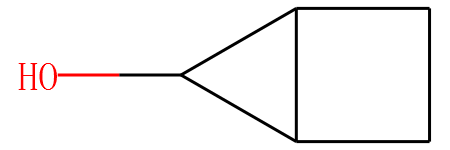

In [6]:
m = Chem.MolFromSmiles('OC1C2C1CC2')
print(m.GetAtomWithIdx(0).IsInRing())
print(m.GetAtomWithIdx(2).IsInRing())
print(m.GetAtomWithIdx(2).IsInRingSize(3))
m

In [7]:
Chem.Draw.MolToFile(m, 'data/atom_bond_ring_1.png')

- 但是要注意，IsInRingSize()函数只能判断是否在最小的环中

In [8]:
print(m.GetAtomWithIdx(2).IsInRingSize(3))
print(m.GetAtomWithIdx(2).IsInRingSize(5))

True
False


- 可以查看所有最小环(smallest set of smallest rings, SSSR）的信息：GetSymmSSSR()

In [9]:
ssr = Chem.GetSymmSSSR(m)
print(len(ssr))
print(list(ssr[0]))
print(list(ssr[1]))

2
[1, 2, 3]
[4, 5, 2, 3]


- 直接获取环的信息：GetRingInfo()
- 查看一共有几个环：NumRings()
- 查看原子在几个环中：NumAtomRings()
- 查看id为n的原子是否在n1元环中.IsAtomInRingOfSize(n, n1)
- 查看id为n的键是否在n1元环中.IsAtomInRingOfSize(n , n1)

In [10]:
ri = m.GetRingInfo()
print(ri.NumRings())
print(ri.NumAtomRings(6))
print(ri.IsAtomInRingOfSize(1,3))
print(ri.IsBondInRingOfSize(1,3))

2
0
True
True


## 4.手动实现氧族药效团查找
这里只做一个简单的演示，通过原子属性查找目标药效团，更复杂的操作类似。
- 假设要查找的氧族氢供体标准：氧或硫原子，不带电荷，含有1个氢。
- 氧族氢受体标准（部分）：不带氢原子，化合价为2，且不与氮原子相连。

In [11]:
def pharmacophore(m):
    atomPharma = {}
    # 定义氧族原子
    chalcogen = [8, 16]
    mol = Chem.MolFromSmiles(m)
    mol = Chem.AddHs(mol)
    # 开始查找
    for atom in mol.GetAtoms():
        p = []
        if atom.GetAtomicNum() == 1 or atom.GetAtomicNum() not in chalcogen:
            continue
        else:
            # 氢供体
            if atom.GetFormalCharge() == 0:
                nbrs = [x for x in atom.GetNeighbors()]
                HDflag = False
                for nbr in nbrs:
                    if nbr.GetAtomicNum() == 1:
                        HDflag = True
                if HDflag:
                    p.append('HDonor')
                    
            # 氢受体
            if atom.GetTotalValence() == 2:
                nbrs = [x for x in atom.GetNeighbors()]
                HAflag_1 = True
                HAflag_2 = True
                if len(nbrs) == 1:
                    nbr = nbrs[0]
                    if nbr.GetAtomicNum() == 7:
                        HAflag_1 = False
                else:
                    for nbr in nbrs:
                        if nbr.GetAtomicNum() == 1:
                            HAflag_2 = False
                if HAflag_1 and HAflag_2:
                    p.append('HAcceptor')
        atomPharma[atom.GetIdx()] = [atom.GetAtomicNum(), ' '.join(p)]
    return atomPharma

m = 'COC(=O)O'
res = pharmacophore(m)
res

{1: [8, 'HAcceptor'], 3: [8, 'HAcceptor'], 4: [8, 'HDonor']}

更简单的操作，直接写成SMARTS查找就可以了
- 氢供体：[O,S;H1;+0]
- 氢受体（部分）：[O;H0;v2;!$(O=N-*)] 

In [12]:
def pharmacophore_smarts(m):
    # 定义smarts
    HDonorSmarts = '[O,S;H1;+0]'
    HAcceptorSmarts = '[O;H0;v2;!$(O=N-*)]'
    HDonor = Chem.MolFromSmarts(HDonorSmarts)
    HAcceptor = Chem.MolFromSmarts(HAcceptorSmarts)
    atomPharma = {}
    mol = Chem.MolFromSmiles(m)
    # 氢供体
    HDonors = mol.GetSubstructMatches(HDonor)
    for i in HDonors:
        atom = mol.GetAtomWithIdx(i[0])
        atomPharma[atom.GetIdx()] = [atom.GetAtomicNum(), 'HDonor']
    # 氢受体
    HAcceptors = mol.GetSubstructMatches(HAcceptor)
    for i in HAcceptors:
        atom = mol.GetAtomWithIdx(i[0])
        atom_prop = atomPharma.get(atom.GetIdx(), [])
        if atom_prop:
            atom_prop[1] = atom_prop[1] + ' HAcceptor'
            atomPharma.update({atom.GetIdx():atom_prop})
        else:
            atomPharma[atom.GetIdx()] = [atom.GetAtomicNum(), 'HAcceptor']
    return atomPharma

res = pharmacophore_smarts(m)
res

{4: [8, 'HDonor'], 1: [8, 'HAcceptor'], 3: [8, 'HAcceptor']}